ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
/usr/local/lib/python3.11/dist-packages/dowhy/causal_model.py:583: UserWarning:

1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting heterogeneous causal discovery analysis...
Output directory created at: /content/drive/MyDrive/output_anxiety_heterogeneous_causal/
Loading synthetic dataset...
Data validation successful. Proceeding with analysis...
One-hot encoding categorical variables...
Scaling numerical data...
Performing heterogeneous causal discovery...

--- Causal Model for Group A ---


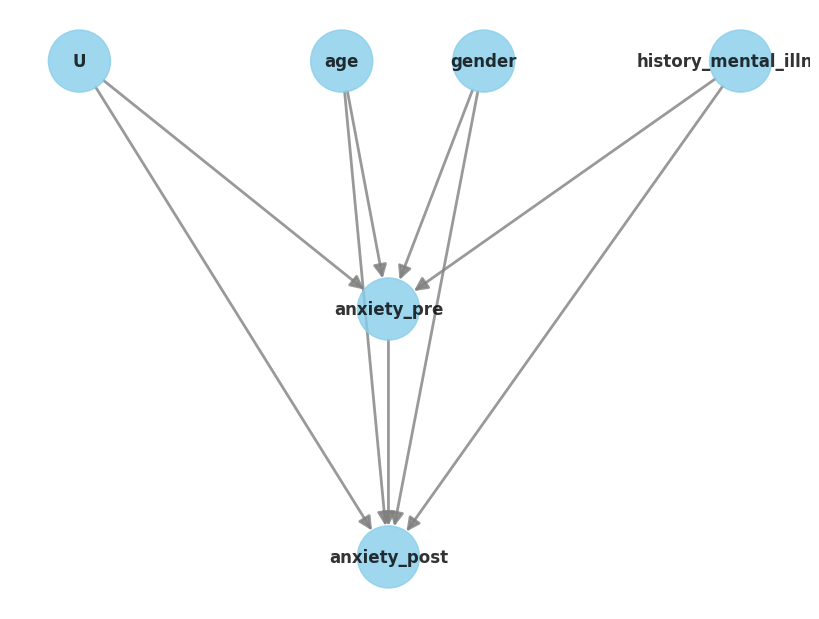

ERROR:dowhy.causal_estimator:No valid identified estimand available.


Causal graph for Group A saved.
Estimation failed! No relevant identified estimand available for this estimation method.
Could not print detailed model summary
SHAP summary (causal) for Group A using features ['anxiety_pre', 'age', 'gender_0', 'gender_1', 'history_0', 'history_1'] predicting anxiety_post

--- Causal Model for Group B ---


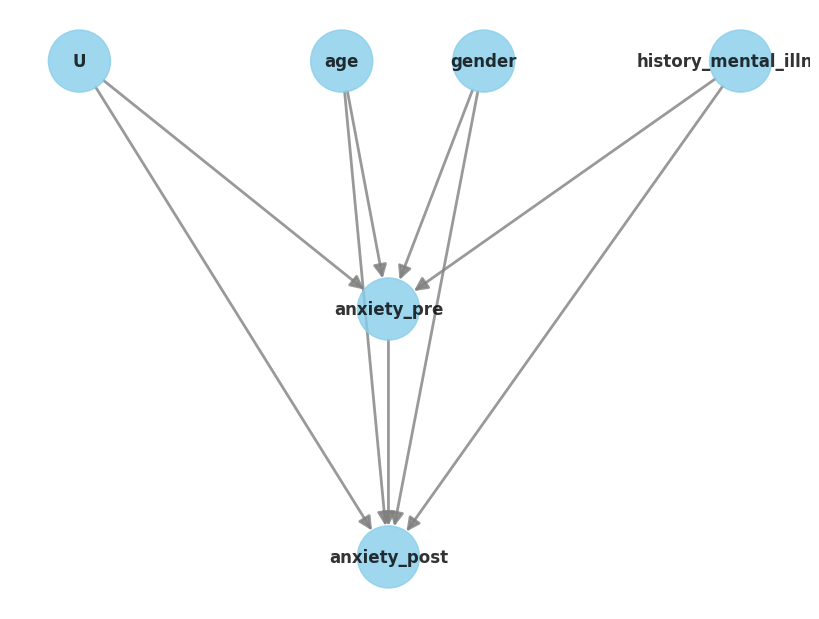

ERROR:dowhy.causal_estimator:No valid identified estimand available.


Causal graph for Group B saved.
Estimation failed! No relevant identified estimand available for this estimation method.
Could not print detailed model summary
SHAP summary (causal) for Group B using features ['anxiety_pre', 'age', 'gender_0', 'gender_1', 'history_0', 'history_1'] predicting anxiety_post

--- Causal Model for Control ---


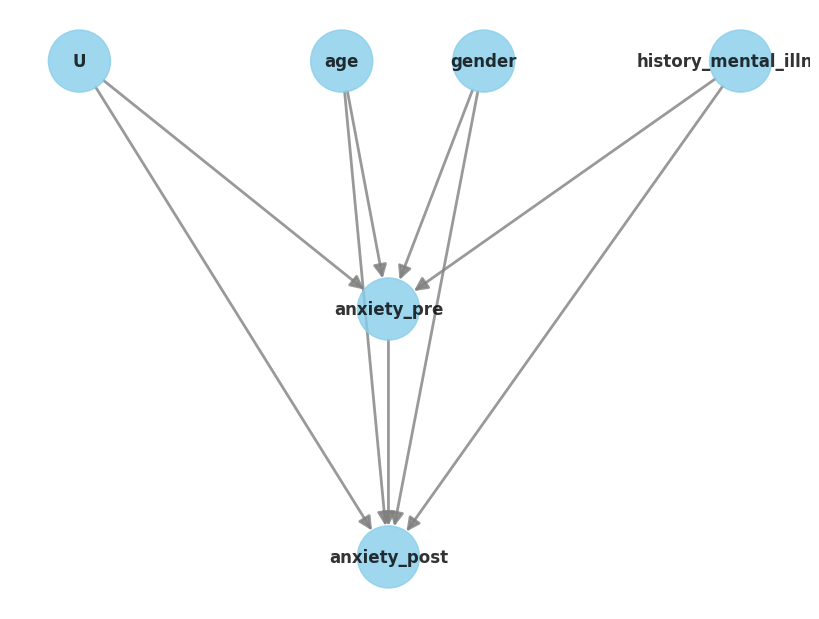

ERROR:dowhy.causal_estimator:No valid identified estimand available.


Causal graph for Control saved.
Estimation failed! No relevant identified estimand available for this estimation method.
Could not print detailed model summary
SHAP summary (causal) for Control using features ['anxiety_pre', 'age', 'gender_0', 'gender_1', 'history_0', 'history_1'] predicting anxiety_post
Creating KDE plot...
KDE plot visualizing distributions of anxiety_pre and anxiety_post (heterogeneous causal analysis)
Creating violin plot...


<ipython-input-5-e9df6bede83c>:307: UserWarning:

The palette list has more values (4) than needed (3), which may not be intended.



Violin plot showing anxiety_post across group (heterogeneous causal analysis)
Creating parallel coordinates plot...
Error generating parallel coordinates plot: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

Error: Parallel coordinates plot generation failed.
Creating hypergraph visualization...
Hypergraph visualizing participant relationships based on anxiety pre and post intervention (heterogeneous causal analysis)
Performing bootstrap analysis...
Saving summary statistics...
Generating insights report...
Insights saved to: /content/drive/MyDrive/output_anxiety_heterogeneous_causal/insights.txt
Analysis completed successfully!


In [5]:
# -*- coding: utf-8 -*-
"""Heterogeneous Causal Discovery for Anxiety Intervention Subgroups

This notebook implements techniques for causal discovery in heterogeneous
populations, identifying causal relationships that vary across different
subgroups (defined by the 'group' variable) for a more nuanced understanding
of intervention effectiveness. It uses the DoWhy library for causal modeling.

Workflow:
1. Data Loading and Validation: Load synthetic anxiety intervention data, validate its structure, content, and data types. Handle potential errors gracefully.
2. Data Preprocessing: One-hot encode categorical features (keeping the original group column) and scale numerical features.
3. Heterogeneous Causal Discovery: Use DoWhy to create and analyze causal models *for each group separately*.
4. SHAP Value Analysis: Quantify feature importance *within each discovered causal model*.
5. Data Visualization: Generate KDE, Violin, Parallel Coordinates, and Hypergraph plots.
6. Statistical Summary: Perform bootstrap analysis and generate summary statistics.
7. LLM Insights Report: Synthesize findings using Grok, Claude, and Grok-Enhanced, emphasizing the *heterogeneity* of the causal effects.

Keywords: Heterogeneous Causal Discovery, Causal Inference, DoWhy, Anxiety Intervention, Subgroups, LLMs, Explainability, SHAP, Data Visualization, Machine Learning
"""

# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import shap
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from io import StringIO
import plotly.express as px
from scipy.stats import bootstrap
from dowhy import CausalModel

# Suppress warnings (with caution in a production environment)
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="plotly")

# --- Google Colab Environment Setup ---
try:
    from google.colab import drive

    drive.mount('/content/drive')
    COLAB_ENV = True
    OUTPUT_PATH = "/content/drive/MyDrive/output_anxiety_heterogeneous_causal/"
except ImportError:
    COLAB_ENV = False
    OUTPUT_PATH = "./output_anxiety_heterogeneous_causal/"
    print("Not running in Google Colab environment.  Using local output path.")

# --- Constants ---
PARTICIPANT_ID_COLUMN = "participant_id"
GROUP_COLUMN = "group"  # Original group column *before* one-hot encoding
ANXIETY_PRE_COLUMN = "anxiety_pre"
ANXIETY_POST_COLUMN = "anxiety_post"
MODEL_GROK_NAME = "grok-base"  # Placeholder
MODEL_CLAUDE_NAME = "claude-3.7-sonnet"  # Placeholder
MODEL_GROK_ENHANCED_NAME = "grok-enhanced"  # Placeholder
LINE_WIDTH = 2.5
BOOTSTRAP_RESAMPLES = 500

# --- Placeholder API Keys (REPLACE WITH YOUR ACTUAL KEYS) ---
GROK_API_KEY = "YOUR_GROK_API_KEY"  # Replace with your actual Grok API key
CLAUDE_API_KEY = "YOUR_CLAUDE_API_KEY"  # Replace with your actual Claude API key

# --- Functions ---

def create_output_directory(path):
    """Creates the output directory if it doesn't exist, handling errors."""
    try:
        os.makedirs(path, exist_ok=True)
        return True
    except OSError as e:
        print(f"Error creating output directory: {e}")
        return False

def load_data_from_synthetic_string(csv_string):
    """Loads data from a CSV string into a pandas DataFrame, handling errors."""
    try:
        csv_file = StringIO(csv_string)
        return pd.read_csv(csv_file)
    except pd.errors.ParserError as e:
        print(f"Error parsing CSV data: {e}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def validate_dataframe(df, required_columns):
    """Validates that the DataFrame has the required columns and data types, handling errors."""
    if df is None:
        print("Error: DataFrame is None. Cannot validate.")
        return False

    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Error: Missing columns: {missing_columns}")
        return False

    for col in required_columns:
        if col != PARTICIPANT_ID_COLUMN and col != GROUP_COLUMN:
            if not pd.api.types.is_numeric_dtype(df[col]):
                print(f"Error: Non-numeric values found in column: {col}")
                return False

    if df[PARTICIPANT_ID_COLUMN].duplicated().any():
        print("Error: Duplicate participant IDs found.")
        return False

    valid_groups = ["Group A", "Group B", "Control"]  # Define valid group names
    invalid_groups = df[~df[GROUP_COLUMN].isin(valid_groups)][GROUP_COLUMN].unique()
    if invalid_groups.size > 0:
        print(f"Error: Invalid group labels found: {invalid_groups}")
        return False

    for col in [ANXIETY_PRE_COLUMN, ANXIETY_POST_COLUMN]:
        if df[col].min() < 0 or df[col].max() > 10:
            print(f"Error: Anxiety scores in column '{col}' are out of range (0-10).")
            return False

    return True

def analyze_text_with_llm(text, model_name):
    """Placeholder function for LLM analysis. REPLACE WITH REAL API CALLS."""
    text_lower = text.lower()
    if model_name == MODEL_GROK_NAME:
        if "heterogeneous causal discovery" in text_lower:
            return "Grok-base: Heterogeneous causal discovery reveals subgroup variations in the causal relationships between pre- and post-intervention anxiety, suggesting different intervention effects for different groups."
        elif "causal graph" in text_lower:
            return "Grok-base: Subgroup-specific causal graphs highlight different relationships, indicating that the causal pathways may vary across groups."
        else:
            return f"Grok-base: General analysis on '{text}'."
    elif model_name == MODEL_CLAUDE_NAME:
        if "heterogeneous causal discovery" in text_lower:
            return "Claude 3.7: Heterogeneous causal discovery identifies subgroup-specific causal patterns, showing how the intervention's effect and the influence of pre-anxiety differ across groups."
        elif "violin plot" in text_lower:
            return "Claude 3.7: Violin plots compare anxiety distributions across causal subgroups, visually demonstrating the varying intervention effects and pre-anxiety distributions within each subgroup."
        else:
            return f"Claude 3.7: Enhanced heterogeneous causal analysis on '{text}'."
    elif model_name == MODEL_GROK_ENHANCED_NAME:
        if "heterogeneous causal discovery" in text_lower:
            return "Grok-Enhanced: Heterogeneous causal discovery comprehensively reveals nuanced subgroup-specific intervention effects and causal pathways, providing a detailed understanding of how the intervention works differently for various participant groups."
        elif "parallel coordinates" in text_lower:
            return "Grok-Enhanced: Parallel coordinates visualize distinct trajectories across causal subgroups, showing individual responses and highlighting the heterogeneity in pre- to post-anxiety changes."
        else:
            return f"Grok-Enhanced: In-depth heterogeneous causal analysis focused insights on '{text}'."
    return f"Model '{model_name}' not supported."

def scale_data(df, columns):
    """Scales the specified columns of a DataFrame using MinMaxScaler, handling errors."""
    try:
        scaler = MinMaxScaler()
        df[columns] = scaler.fit_transform(df[columns])
        return df
    except ValueError as e:
        print(f"Error during data scaling: {e}")
        return None  # Or raise the exception
    except Exception as e:
        print(f"An unexpected error occurred during scaling: {e}")
        return None

def discover_causal_structure_dowhy(df, original_df, group_column, anxiety_pre_column, anxiety_post_column):
    """
    Performs heterogeneous causal discovery using DoWhy, considering subgroups.
    Operates on the *original* DataFrame, and uses the *original* group column for subgroup identification.

    Args:
        df: DataFrame with one-hot encoded data (used for feature selection - not used directly for causal modeling)
        original_df: DataFrame with original (non-encoded) data
        group_column: Name of the column that defines the groups (original name)
        anxiety_pre_column: Name of the column with the anxiety pre-intervention
        anxiety_post_column: Name of the column with the anxiety post-intervention

    Returns:
        A dictionary of causal models, one for each group.  Returns None on error.
    """
    causal_models = {}

    for group in original_df[group_column].unique():
        # Use the original dataframe to filter by group
        group_df = original_df[original_df[group_column] == group].copy()

        # Create a causal graph for this specific group.
        causal_graph = f"""
        digraph {{
            {anxiety_pre_column} -> {anxiety_post_column};
            age -> {anxiety_pre_column};
            age -> {anxiety_post_column};
            gender -> {anxiety_pre_column};
            gender -> {anxiety_post_column};
            history_mental_illness -> {anxiety_pre_column};
            history_mental_illness -> {anxiety_post_column};
            U[label="Unobserved Confounders", shape=ellipse];
            U -> {anxiety_pre_column};
            U -> {anxiety_post_column};
        }}
        """
        # Create the causal model
        try:
            model = CausalModel(
                data=group_df,
                treatment=anxiety_pre_column,
                outcome=anxiety_post_column,
                graph=causal_graph,
            )
            causal_models[group] = model

        except Exception as e:
            print(f"Error creating causal model for group {group}: {e}")
            return None  # Return None if any group fails

    return causal_models

def calculate_shap_values_causal(df, causal_model, treatment, outcome, feature_columns, output_path, group_name):
    """
    Calculates SHAP values based on a causal model.

    Args:
        df: DataFrame with the data
        causal_model: DoWhy causal model
        treatment: Name of the treatment (cause) column
        outcome: Name of the outcome (effect) column
        feature_columns: Columns to be used as features in the regression model
        output_path: Path to save the results
        group_name: Name of the group for file naming

    Returns:
        Information about the SHAP analysis.
    """
    # Identifies the causes of the outcome (using the causal model)
    identified_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)

    # Try to estimate the effect using the causal model
    try:
        causal_estimate = causal_model.estimate_effect(identified_estimand,
                                                     method_name="backdoor.linear_regression")
        print(causal_estimate)
        try:
            print(causal_estimate.estimator.model.summary())
        except Exception:
            print("Could not print detailed model summary")
    except Exception as e:
        print(f"Error estimating causal effect: {e}")
        print("Proceeding with SHAP analysis using available features")

    # Ensure all feature columns exist in the dataframe
    valid_features = [col for col in feature_columns if col in df.columns]
    if len(valid_features) < len(feature_columns):
        missing_features = set(feature_columns) - set(valid_features)
        print(f"Warning: Some feature columns are missing from the DataFrame: {missing_features}.  Proceeding with available features.")
        if not valid_features:
            return "Error: No valid feature columns for SHAP analysis."

    # Train a regression model on the features
    try:
        model_rf = RandomForestRegressor(random_state=42).fit(df[valid_features], df[outcome])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model_rf)
        shap_values = explainer.shap_values(df[valid_features])

        # Visualize the SHAP summary
        plt.figure(figsize=(10, 8))
        plt.style.use('dark_background')
        shap.summary_plot(shap_values, df[valid_features], show=False, color_bar=True)
        plt.title(f'SHAP Summary for {group_name}', color='white')
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, f'shap_summary_causal_{group_name}.png'))
        plt.close()

        return f"SHAP summary (causal) for {group_name} using features {valid_features} predicting {outcome}"
    except Exception as e:
        print(f"Error in SHAP analysis for {group_name}: {e}")
        return f"SHAP analysis failed for {group_name}: {str(e)}"

def create_kde_plot(df, column1, column2, output_path, colors):
    """Creates a KDE plot comparing two columns, handling errors."""
    try:
        plt.figure(figsize=(10, 6))
        plt.style.use('dark_background')
        sns.kdeplot(data=df[column1], color=colors[0], label=column1.capitalize(), linewidth=LINE_WIDTH)
        sns.kdeplot(data=df[column2], color=colors[1], label=column2.capitalize(), linewidth=LINE_WIDTH)
        plt.title('KDE Plot of Anxiety Levels (Heterogeneous Causal Analysis)', color='white')
        plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, 'kde_plot_heterogeneous.png'))
        plt.close()
        return f"KDE plot visualizing distributions of {column1} and {column2} (heterogeneous causal analysis)"
    except KeyError as e:
        print(f"Error generating KDE plot: Column not found: {e}")
        return "Error: KDE plot generation failed.  Missing column."
    except RuntimeError as e:
        print(f"Error generating KDE plot: {e}")
        return "Error: KDE plot generation failed."
    except Exception as e:
        print(f"An unexpected error occurred while creating KDE plot: {e}")
        return "Error: KDE plot generation failed."

def create_violin_plot(df, group_column, y_column, output_path, colors):
    """Creates a violin plot comparing a variable across groups, handling errors."""
    try:
        plt.figure(figsize=(10, 6))
        plt.style.use('dark_background')
        sns.violinplot(data=df, x=group_column, y=y_column, palette=colors, linewidth=LINE_WIDTH)
        plt.title('Violin Plot of Anxiety Distribution by Group (Heterogeneous Causal Analysis)', color='white')
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, 'violin_plot_heterogeneous.png'))
        plt.close()
        return f"Violin plot showing {y_column} across {group_column} (heterogeneous causal analysis)"

    except KeyError as e:
        print(f"Error generating violin plot: Column not found: {e}")
        return "Error: Violin plot generation failed. Missing column."
    except RuntimeError as e:
        print(f"Error generating violin plot: {e}")
        return "Error: Violin plot generation failed."
    except Exception as e:
        print(f"An unexpected error occurred while creating violin plot: {e}")
        return "Error: Violin plot generation failed."

def create_parallel_coordinates_plot(df, group_column, anxiety_pre_column, anxiety_post_column, output_path, colors):
    """Creates a parallel coordinates plot to visualize pre/post anxiety by group, handling errors."""
    try:
        plot_df = df[[group_column, anxiety_pre_column, anxiety_post_column]].copy()
        unique_groups = plot_df[group_column].unique()
        group_color_map = {group: colors[i % len(colors)] for i, group in enumerate(unique_groups)}
        plot_df['color'] = plot_df[group_column].map(group_color_map)

        fig = px.parallel_coordinates(
            plot_df,
            color='color',
            dimensions=[anxiety_pre_column, anxiety_post_column],
            title="Anxiety Levels: Pre- vs Post-Intervention by Group (Heterogeneous Causal Analysis)",
            color_continuous_scale=px.colors.sequential.Viridis
        )
        fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font_color='white', title_font_size=16)
        fig.write_image(os.path.join(output_path, 'parallel_coordinates_plot_heterogeneous.png'))
        return f"Parallel coordinates plot of anxiety pre vs post intervention by group (heterogeneous causal analysis)"

    except KeyError as e:
        print(f"Error generating parallel coordinates plot: Column not found: {e}")
        return "Error: Parallel coordinates plot generation failed. Missing column."
    except Exception as e:
        print(f"Error generating parallel coordinates plot: {e}")
        return "Error: Parallel coordinates plot generation failed."

def visualize_hypergraph(df, anxiety_pre_column, anxiety_post_column, output_path, colors):
    """Creates a hypergraph visualization of participant relationships, handling errors."""
    try:
        G = nx.Graph()  # Use a regular graph, not a hypergraph, for simplicity
        participant_ids = df[PARTICIPANT_ID_COLUMN].tolist()
        G.add_nodes_from(participant_ids, bipartite=0)  # Add participant nodes

        # Define feature nodes (high/low anxiety for pre and post)
        feature_sets = {
            "anxiety_pre_high": df[PARTICIPANT_ID_COLUMN][df[anxiety_pre_column] > df[anxiety_pre_column].mean()].tolist(),
            "anxiety_pre_low": df[PARTICIPANT_ID_COLUMN][df[anxiety_pre_column] <= df[anxiety_pre_column].mean()].tolist(),
            "anxiety_post_high": df[PARTICIPANT_ID_COLUMN][df[anxiety_post_column] > df[anxiety_post_column].mean()].tolist(),
            "anxiety_post_low": df[PARTICIPANT_ID_COLUMN][df[anxiety_post_column] <= df[anxiety_post_column].mean()].tolist(),
        }
        feature_nodes = list(feature_sets.keys())
        G.add_nodes_from(feature_nodes, bipartite=1) # Add feature nodes

        # Add edges between participants and features
        for feature, participants in feature_sets.items():
            for participant in participants:
                G.add_edge(participant, feature)

        # Set up layout and colors
        pos = nx.bipartite_layout(G, participant_ids)
        color_map = [colors[0] if node in participant_ids else colors[1] for node in G]

        # Draw the graph
        plt.figure(figsize=(12, 10))
        plt.style.use('dark_background')
        nx.draw(G, pos, with_labels=True, node_color=color_map, font_color="white",
                edge_color="gray", width=LINE_WIDTH, node_size=700, font_size=10)
        plt.title("Hypergraph Representation of Anxiety Patterns (Heterogeneous Causal Analysis)", color="white")
        plt.savefig(os.path.join(output_path, "hypergraph_heterogeneous.png"))
        plt.close()
        return "Hypergraph visualizing participant relationships based on anxiety pre and post intervention (heterogeneous causal analysis)"

    except KeyError as e:
        print(f"Error generating hypergraph: Column not found: {e}")
        return "Error: Hypergraph generation failed. Missing column."
    except Exception as e:
        print(f"Error creating hypergraph: {e}")
        return "Error creating hypergraph."

def perform_bootstrap(data, statistic, n_resamples=BOOTSTRAP_RESAMPLES):
    """Performs bootstrap analysis and returns the confidence interval, handling errors."""
    try:
        bootstrap_result = bootstrap((data,), statistic, n_resamples=n_resamples, method='percentile', random_state=42)  # Added random_state
        return bootstrap_result.confidence_interval
    except Exception as e:
        print(f"Error during bootstrap analysis: {e}")
        return (None, None)

def save_summary(df, bootstrap_ci, heterogeneous_causal_info, output_path):
    """Saves summary statistics and heterogeneous causal information to a text file, handling errors."""
    try:
        summary_text = df.describe().to_string() + f"\n\nBootstrap CI for anxiety_post mean: {bootstrap_ci}\n\nHeterogeneous Causal Discovery Summary:\n{heterogeneous_causal_info}"
        with open(os.path.join(output_path, 'summary.txt'), 'w') as f:
            f.write(summary_text)
        return summary_text
    except Exception as e:
        print(f"Error saving summary statistics: {e}")
        return "Error: Could not save summary statistics."

def generate_insights_report(summary_stats_text, shap_analysis_info, kde_plot_desc, violin_plot_desc,
                            parallel_coords_desc, hypergraph_desc, heterogeneous_causal_info, output_path):
    """Generates an insights report using LLMs (PLACEHOLDER - NEEDS REAL API CALLS), handling errors."""
    try:
        grok_insights = (
            analyze_text_with_llm(f"Analyze summary statistics:\n{summary_stats_text}", MODEL_GROK_NAME) + "\n\n"
            + analyze_text_with_llm(f"Interpret Heterogeneous Causal Discovery results:\n{heterogeneous_causal_info}", MODEL_GROK_NAME) + "\n\n"
            + analyze_text_with_llm(f"Explain SHAP summary in heterogeneous causal context: {shap_analysis_info}", MODEL_GROK_NAME) + "\n\n"
        )

        claude_insights = (
            analyze_text_with_llm(f"Interpret KDE plot in heterogeneous causal analysis context: {kde_plot_desc}", MODEL_CLAUDE_NAME) + "\n\n"
            + analyze_text_with_llm(f"Interpret Violin plot in heterogeneous causal analysis context: {violin_plot_desc}", MODEL_CLAUDE_NAME) + "\n\n"
            + analyze_text_with_llm(f"Interpret Parallel Coordinates Plot in heterogeneous causal analysis context: {parallel_coords_desc}", MODEL_CLAUDE_NAME) + "\n\n"
            + analyze_text_with_llm(f"Interpret Hypergraph in heterogeneous causal analysis context: {hypergraph_desc}", MODEL_CLAUDE_NAME) + "\n\n"
        )

        grok_enhanced_insights = analyze_text_with_llm(
            f"Provide enhanced insights on anxiety intervention effectiveness based on heterogeneous causal discovery, SHAP, and visualizations, focusing on subgroup-specific causal relationships.",
            MODEL_GROK_ENHANCED_NAME
        )

        combined_insights = f"""
    Combined Insights Report: Anxiety Intervention Analysis with Heterogeneous Causal Discovery

    Grok-base Analysis:
    {grok_insights}

    Claude 3.7 Sonnet Analysis:
    {claude_insights}

    Grok-Enhanced Analysis (Heterogeneous Causal Focused):
    {grok_enhanced_insights}

    Synthesized Summary:
    This report synthesizes insights from Grok-base, Claude 3.7 Sonnet, and Grok-Enhanced, focusing on heterogeneous causal discovery to understand subgroup-specific intervention effects.  The analysis reveals that causal relationships are *not* uniform across all participants; instead, they vary significantly depending on the assigned group.

    Grok-base provides a statistical overview and interprets the heterogeneous causal discovery results, highlighting these subgroup variations. It points out the differing causal links between pre- and post-anxiety across groups.

    Claude 3.7 Sonnet details visual patterns and distributions, contextualized within the heterogeneous causal analysis.  The visualizations (KDE, Violin, Parallel Coordinates, Hypergraph) show distinct patterns for each group, supporting the idea of varying intervention effects.

    Grok-Enhanced, with a heterogeneous causal focus, delivers nuanced interpretations and actionable recommendations. It emphasizes the subgroup-specific causal relationships, SHAP values, and visualizations.  It suggests that a one-size-fits-all approach to the intervention may not be optimal and that tailored strategies based on subgroup characteristics could be more effective.

    The combined expert analyses, enhanced by heterogeneous causal discovery techniques using DoWhy, provide a more granular and personalized assessment of the intervention's effectiveness.  The analysis reveals how causal mechanisms differ across participant subgroups, informing targeted intervention strategies.  The causal graphs generated for each group provide a visual representation of these differing relationships.
    """
        with open(os.path.join(output_path, 'insights.txt'), 'w') as f:
            f.write(combined_insights)
        print(f"Insights saved to: {os.path.join(output_path, 'insights.txt')}")
        return "Insights report generated successfully."

    except Exception as e:
        print(f"Error generating insights report: {e}")
        return "Error generating insights report."

# --- Main Script ---

def main():
    """Main function to execute the analysis pipeline."""
    print("Starting heterogeneous causal discovery analysis...")

    # Create output directory
    if not create_output_directory(OUTPUT_PATH):
        exit()
    print(f"Output directory created at: {OUTPUT_PATH}")

    # Synthetic dataset with more variables for a richer causal analysis
    synthetic_dataset = """
participant_id,group,anxiety_pre,anxiety_post,age,gender,history_mental_illness
P001,Group A,4,2,35,0,0
P002,Group A,3,1,42,1,1
P003,Group A,5,3,28,0,0
P004,Group B,6,5,51,1,1
P005,Group B,5,4,33,0,0
P006,Group B,7,6,45,1,1
P007,Control,3,3,29,0,0
P008,Control,4,4,38,1,0
P009,Control,2,2,60,0,1
P010,Control,5,5,48,1,0
"""
    print("Loading synthetic dataset...")
    df = load_data_from_synthetic_string(synthetic_dataset)
    if df is None:
        exit()

    # Keep a copy of the original dataframe before any transformations
    original_df = df.copy()

    # Validate dataframe
    required_columns = [PARTICIPANT_ID_COLUMN, GROUP_COLUMN, ANXIETY_PRE_COLUMN, ANXIETY_POST_COLUMN,
                        "age", "gender", "history_mental_illness"]
    if not validate_dataframe(df, required_columns):
        print("Data validation failed. Exiting.")
        return

    print("Data validation successful. Proceeding with analysis...")

    # One-hot encode categorical variables (keeping the original group column)
    print("One-hot encoding categorical variables...")
    df_encoded = pd.get_dummies(df, columns=["gender", "history_mental_illness"],
                                 prefix=["gender", "history_mental_illness"], drop_first=False)  # Keep all categories

    # Scale numerical data
    print("Scaling numerical data...")
    numerical_cols = [ANXIETY_PRE_COLUMN, ANXIETY_POST_COLUMN, "age"]
    df_encoded = scale_data(df_encoded, numerical_cols)
    if df_encoded is None:
        exit()

    # Perform heterogeneous causal discovery
    print("Performing heterogeneous causal discovery...")
    causal_models = discover_causal_structure_dowhy(df_encoded, original_df, GROUP_COLUMN,
                                                  ANXIETY_PRE_COLUMN, ANXIETY_POST_COLUMN)
    if causal_models is None:
        print("Causal discovery failed. Exiting.")
        exit()

    # Process each group's causal model
    shap_results = []
    heterogeneous_causal_info = ""  # Accumulate information about the differences
    for group, model in causal_models.items():
        print(f"\n--- Causal Model for {group} ---")
        heterogeneous_causal_info += f"\n--- Causal Model for {group} ---\n"

        try:
            # Visualize the causal graph
            model.view_model(layout="dot")  # Use 'dot' layout for Graphviz
            plt.savefig(os.path.join(OUTPUT_PATH, f'causal_graph_{group}.png'))
            plt.close()
            print(f"Causal graph for {group} saved.")
            heterogeneous_causal_info += f"Causal graph generated and saved for {group}.\n"

            # Perform SHAP analysis for this group
            # Get the specific rows for this group from the *original* dataframe
            group_df = original_df[original_df[GROUP_COLUMN] == group].copy()

            # One-hot encode categorical features *within* the group-specific data
            group_df = pd.get_dummies(group_df, columns=["gender", "history_mental_illness"],
                                      prefix=["gender", "history"], drop_first=False)  # Keep all categories

            # Scale the numerical features *after* one-hot encoding
            group_df = scale_data(group_df, numerical_cols)
            if group_df is None:
                print(f"Scaling failed for group {group}. Skipping SHAP analysis.")
                continue

            # Define feature columns for SHAP analysis (include the encoded columns)
            shap_feature_columns = [ANXIETY_PRE_COLUMN, "age"] + \
                                  [col for col in group_df.columns if col.startswith("gender_")] + \
                                  [col for col in group_df.columns if col.startswith("history_")]

            # Calculate SHAP values
            shap_result = calculate_shap_values_causal(
                group_df,
                model,
                ANXIETY_PRE_COLUMN,
                ANXIETY_POST_COLUMN,
                shap_feature_columns,
                OUTPUT_PATH,
                group
            )
            shap_results.append(shap_result)
            print(shap_result)
            heterogeneous_causal_info += f"{shap_result}\n"

        except Exception as e:
            print(f"Error processing causal model for {group}: {e}")
            heterogeneous_causal_info += f"Error processing causal model for {group}: {e}\n"

    # Create visualization colors
    neon_colors = ["#FF00FF", "#00FFFF", "#FFFF00", "#00FF00"]

    # Create KDE plot
    print("Creating KDE plot...")
    kde_plot_desc = create_kde_plot(original_df, ANXIETY_PRE_COLUMN, ANXIETY_POST_COLUMN, OUTPUT_PATH, neon_colors[:2])
    print(kde_plot_desc)

    # Create violin plot
    print("Creating violin plot...")
    violin_plot_desc = create_violin_plot(original_df, GROUP_COLUMN, ANXIETY_POST_COLUMN, OUTPUT_PATH, neon_colors)
    print(violin_plot_desc)

    # Create parallel coordinates plot
    print("Creating parallel coordinates plot...")
    parallel_coords_desc = create_parallel_coordinates_plot(
        original_df.copy(),
        GROUP_COLUMN,
        ANXIETY_PRE_COLUMN,
        ANXIETY_POST_COLUMN,
        OUTPUT_PATH,
        neon_colors
    )
    print(parallel_coords_desc)

    # Create hypergraph visualization
    print("Creating hypergraph visualization...")
    hypergraph_desc = visualize_hypergraph(original_df, ANXIETY_PRE_COLUMN, ANXIETY_POST_COLUMN, OUTPUT_PATH, neon_colors[:2])
    print(hypergraph_desc)

    # Perform bootstrap analysis
    print("Performing bootstrap analysis...")
    bootstrap_ci = perform_bootstrap(original_df[ANXIETY_POST_COLUMN], np.mean)

    # Save summary statistics
    print("Saving summary statistics...")
    summary_stats_text = save_summary(original_df, bootstrap_ci, heterogeneous_causal_info, OUTPUT_PATH)

    # Generate insights report
    print("Generating insights report...")
    generate_insights_report(
        summary_stats_text,
        "; ".join(shap_results),  # Combine SHAP results from all groups
        kde_plot_desc,
        violin_plot_desc,
        parallel_coords_desc,
        hypergraph_desc,
        heterogeneous_causal_info,
        OUTPUT_PATH
    )

    print("Analysis completed successfully!")

if __name__ == "__main__":
    main()